In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
dataset = get_dataset("electricity")

D:\Anaconda3\lib\site-packages\gluonts\dataset\common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
D:\Anaconda3\lib\site-packages\gluonts\dataset\common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
D:\Anaconda3\lib\site-packages\gluonts\dataset\common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
D:\Anaconda3\lib\site-packages\gluonts\dataset\common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
D:\Anaconda3\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


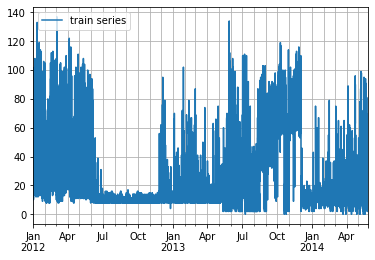

In [4]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

D:\Anaconda3\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


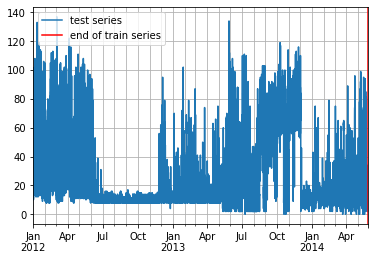

In [5]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [6]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: 1H


In [7]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [8]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [9]:
predictor = estimator.train(dataset.train)

  0%|                                                  | 0/100 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
D:\Anaconda3\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|█████████| 100/100 [00:05<00:00, 16.92it/s, epoch=5/5, avg_epoch_loss=6.1]


In [10]:
from gluonts.evaluation import make_evaluation_predictions

In [11]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [12]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [13]:
# first entry of the time series list
ts_entry = tss[0]

In [14]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([14., 18., 21., 20., 22.], dtype=float32)

In [15]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [16]:
# first 5 values
dataset_test_entry['target'][:5]

array([14., 18., 21., 20., 22.], dtype=float32)

In [17]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [18]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2014-05-26 20:00:00
Frequency of the time series: 1H


In [19]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 6.655583   7.8852634  2.4745417 10.722386  12.529995  20.168703
  2.0248215  2.2366292  7.4199467  5.8252187 12.338335   9.5407915
 25.667795  28.779446   8.425762  10.88596    7.5460505  1.0496942
  4.2852907  5.9861174  1.9821817  2.0036318  8.974063   6.9622674]
0.5-quantile (median) of the future window:
 [ 6.7885137  8.100562   2.471946  10.237126  12.504239  20.279726
  2.083035   1.4208052  7.503015   5.8090625 12.323442   9.540769
 25.868572  28.762691   8.450432  12.04816    7.454447   1.1128012
  4.360235   5.989337   2.0515633  1.9133047  9.10173    6.9623218]


In [20]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

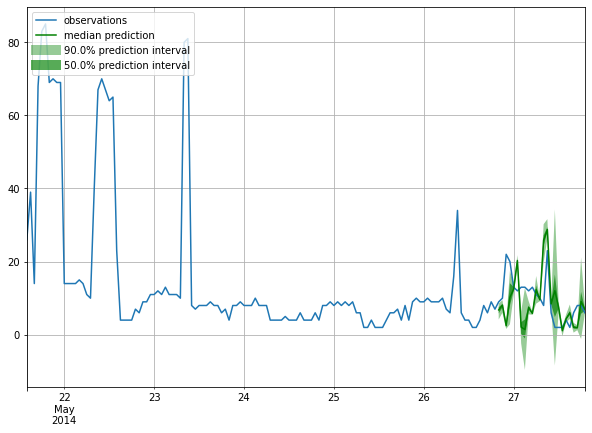

In [21]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [22]:
from gluonts.evaluation import Evaluator

In [23]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|                             | 0/2247 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\gluonts\evaluation\_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 100%|█████████████████| 2247/2247 [00:10<00:00, 207.59it/s]
D:\Anaconda3\lib\site-packages\pandas\core\construction.py:757: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [24]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 2240391.909247337,
    "abs_error": 11363795.447856903,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631948,
    "seasonal_error": 189.4933819611677,
    "MASE": 1.0602347738835474,
    "MAPE": 0.17734541942901885,
    "sMAPE": 0.14800530488820682,
    "MSIS": 12.79994828158722,
    "QuantileLoss[0.1]": 6084697.944644259,
    "Coverage[0.1]": 0.09642486278000285,
    "QuantileLoss[0.5]": 11363795.393211953,
    "Coverage[0.5]": 0.49517875686099916,
    "QuantileLoss[0.9]": 6367844.107573978,
    "Coverage[0.9]": 0.8958426049547511,
    "RMSE": 1496.7938766735174,
    "NRMSE": 0.6275149284546462,
    "ND": 0.08834279955330346,
    "wQuantileLoss[0.1]": 0.04730279186497323,
    "wQuantileLoss[0.5]": 0.08834279912849047,
    "wQuantileLoss[0.9]": 0.049503986424551866,
    "mean_absolute_QuantileLoss": 7938779.14847673,
    "mean_wQuantileLoss": 0.06171652580600518,
    "MAE_Coverage": 0.004184591801415639,
    "OWA": NaN
}


In [25]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,57.791656,137.064346,235.0,9.791667,8.031874,0.711044,0.843889,0.669403,14.384581,87.312767,0.250000,137.064352,0.458333,116.879629,0.541667
1,1.0,75.725149,150.496338,2499.0,104.125000,9.577165,0.654753,0.060061,0.059843,8.048694,77.068529,0.000000,150.496338,0.708333,121.388814,0.958333
2,2.0,0.931511,18.620155,190.0,7.916667,8.673073,0.089454,0.096843,0.100605,0.792554,7.462004,0.041667,18.620154,0.541667,12.213230,0.833333
3,3.0,2973.226237,1090.951416,10468.0,436.166667,48.398763,0.939204,0.102305,0.106277,5.944219,421.038812,0.000000,1090.951355,0.375000,491.221307,0.875000
4,4.0,573.751668,495.119019,4087.0,170.291667,25.383302,0.812737,0.126960,0.123424,4.462762,232.866693,0.208333,495.119003,0.458333,156.689780,0.791667
